In [1]:
import os
from os.path import join, abspath

import sys
sys.path.append(abspath('..'))
import pandas as pd
import numpy as np

from utils import get_dataset, get_target, Preprocessor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from warnings import simplefilter
simplefilter("ignore")

RANDOM_STATE = 25
np.random.seed(RANDOM_STATE)

EPS = 10e-10


DATA_PATH = join(os.getcwd(), '..', 'data', 'events')

## 1. Load dataset

In [2]:
event_keys = os.listdir(DATA_PATH)
event_keys = [ek for ek in event_keys if ek.isdigit()]
event_dirs = [join(DATA_PATH, ek) for ek in event_keys]
len(event_dirs)

5

In [3]:
teams, players = get_dataset(event_dirs)
teams = teams.dropna()
players = players.dropna()

Player with id=15573 has no matching team_id.
Player with id=16848 has no matching team_id.
Player with id=16080 has no matching team_id.
Player with id=21816 has no matching team_id.
Player with id=18163 has no matching team_id.
Player with id=21217 has no matching team_id.
Player with id=13618 has no matching team_id.
Player with id=20170 has no matching team_id.
Player with id=13602 has no matching team_id.
Player with id=11777 has no matching team_id.
Player with id=16080 has no matching team_id.
Player with id=19164 has no matching team_id.


In [4]:
date_cols = ["start_time", "end_time", "start_at", "ends_at"]
team_drop_cols = ["event_fil", "ranking_fil",
                  "is_lan", "is_qual", "prize_pool", "duration", "event_id"]
team_drop_cols += [f"player_id_{i + 1}" for i in range(5)]

In [5]:
df = players.drop(date_cols, axis=1).merge(teams.drop(team_drop_cols + date_cols, axis=1), on="team_id").drop_duplicates()
df["target"] = get_target(df.expected_pts_target, df.wr_target)
df

,rating,dpr,kast,impact,adr,kpr,total_kills,hs,kd,gdr,...,avg_place,winrate,avg_match_intensity,avg_win_intensity,avg_loss_intensity,winstreak,matches_played,wr_target,team_name,target
0,1.12,0.65,72.8,1.21,79.0,0.68,296,49.0,1.04,8.0,...,6.000000,0.666667,1.247255,1.555568,0.630631,0,9,0.333333,virtuspro,4.000
1,1.12,0.65,72.8,1.21,79.0,0.68,296,49.0,1.04,8.0,...,5.000000,0.666667,1.828882,2.424179,0.638289,6,24,0.333333,virtuspro,4.000
4,1.12,0.65,72.8,1.21,79.0,0.68,296,49.0,1.04,8.0,...,6.500000,0.666667,1.212049,1.568074,0.500000,1,6,0.333333,virtuspro,4.000
5,1.12,0.65,72.8,1.21,79.0,0.68,296,49.0,1.04,8.0,...,7.333333,0.500000,1.091021,1.579982,0.602060,0,14,0.333333,virtuspro,4.000
6,1.12,0.65,72.8,1.21,79.0,0.68,296,49.0,1.04,8.0,...,5.357143,0.636364,1.968788,2.693791,0.700033,4,22,0.625000,virtuspro,6.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499805,1.00,0.68,71.0,0.99,73.4,0.60,148,54.7,0.88,4.6,...,5.187500,0.592593,2.179399,3.223727,0.660376,3,27,0.400000,pain,-0.600
499902,1.10,0.68,73.0,1.18,78.5,0.67,526,47.9,0.99,6.1,...,5.250000,0.571429,1.727896,2.579024,0.593059,1,14,0.400000,pain,-0.600
499903,1.10,0.68,73.0,1.18,78.5,0.67,526,47.9,0.99,6.1,...,10.000000,0.000000,0.692308,0.000000,0.692308,0,2,0.400000,pain,-0.600
499904,1.10,0.68,73.0,1.18,78.5,0.67,526,47.9,0.99,6.1,...,6.000000,0.600000,1.977236,2.981291,0.471154,2,10,0.400000,pain,-0.600


## 2. Modelling

In [6]:
event_keys

['7755', '7440', '7437', '6976', '7148']

In [7]:
train_events = [7755, 7440, 7437, 6976]
test_events = [int(ek) for ek in event_keys if int(ek) not in train_events]

In [8]:
target_col = ["target"]

drop_cols = ["event_id", "player_id", "team_id", "team_name", "player_name", # meta
             "duration", "maps_played", "kpr",                               # correlated
             "wr_target", "expected_pts_target",                             # unknown values
             "event_fil"] + target_col

cat_cols = ["ranking_fil"]
bin_cols = ["has_roster_change", "is_lan", "is_qual", "is_awp"]

df[bin_cols] = df[bin_cols].astype(np.float64)
df[target_col] = df[target_col].astype(np.float64)

In [9]:
train = df[df.event_id.isin(train_events)].sample(frac=1).reset_index(drop=True)
test = df[df.event_id.isin(test_events)].sample(frac=1).reset_index(drop=True)

X_train, y_train = train.drop(drop_cols, axis=1), train[target_col].astype(np.float64)
X_test, y_test = test.drop(drop_cols, axis=1), test[target_col].astype(np.float64)

In [10]:
pipe = Pipeline([
    ("preprocessor", Preprocessor(cat_cols=cat_cols, bin_cols=bin_cols)),
    ("estimator", Ridge(alpha=1))
])

In [11]:
pipe.fit(X_train, y_train)
y_preds = pipe.predict(X_test)
mean_squared_error(y_test, y_preds)

34.95140289647478

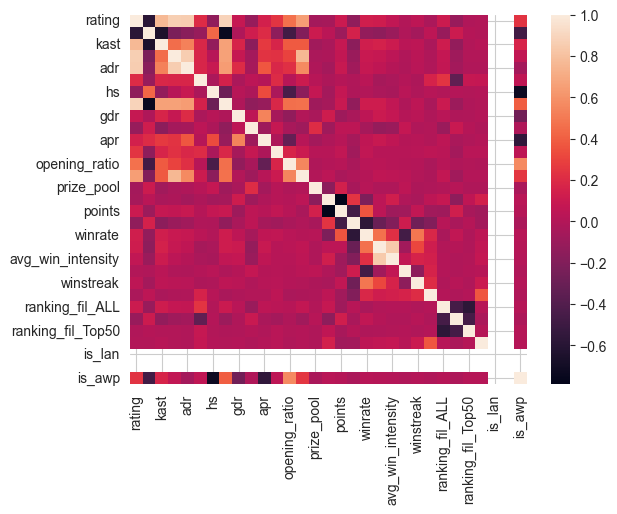

In [12]:
p = Preprocessor(cat_cols=cat_cols, bin_cols=bin_cols)
p.fit(X_train, y_train)
X_train_prep = p.transform(X_train)

sns.heatmap(X_train_prep.corr());

In [13]:
n = 15

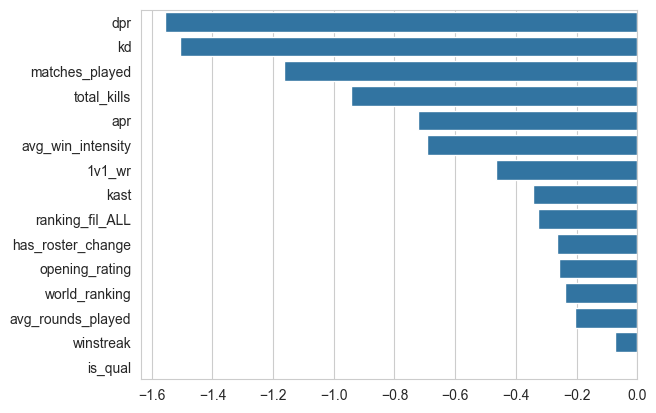

In [14]:
idx = np.argsort(pipe["estimator"].coef_.ravel())[:n]
sns.barplot(x=pipe["estimator"].coef_.ravel()[idx],
            y=pipe["preprocessor"].features.ravel()[idx]);

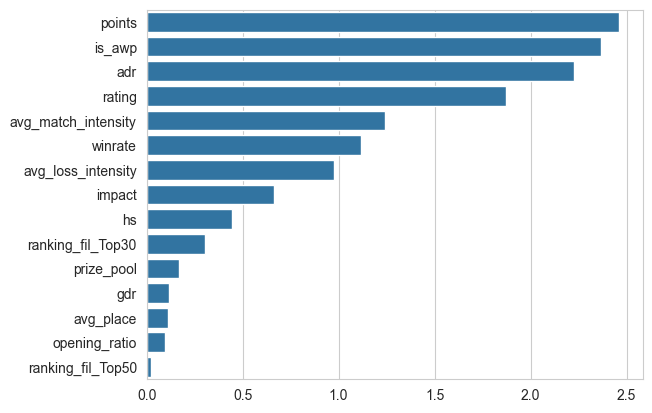

In [15]:
idx = np.argsort(pipe["estimator"].coef_.ravel())[::-1][:n]
sns.barplot(x=pipe["estimator"].coef_.ravel()[idx],
            y=pipe["preprocessor"].features.ravel()[idx]);

In [16]:
final = test[target_col + ["team_name", "player_name"]]
final["pred_target"] = y_preds
final = final.groupby(["player_name"]).max()
final.sort_values(["target"], ascending=False).head(10)

,target,team_name,pred_target
player_name,,,
donk,20.500000,spirit,36.495764
torzsi,19.000000,mouz,17.810342
m0nesy,18.000000,g2,24.747172
brollan,17.750000,mouz,23.490381
jimpphat,17.000000,mouz,17.826535
sh1ro,14.750000,spirit,27.570862
flamez,13.666667,vitality,15.805050
jl,13.250000,natus-vincere,17.558841
spinx,12.833333,vitality,17.110326


In [17]:
final.sort_values(["pred_target"], ascending=False).head(10)

,target,team_name,pred_target
player_name,,,
donk,20.500000,spirit,36.495764
sh1ro,14.750000,spirit,27.570862
zont1x,8.250000,spirit,25.055418
m0nesy,18.000000,g2,24.747172
brollan,17.750000,mouz,23.490381
ax1le,12.600000,cloud9,22.924826
zywoo,12.166667,vitality,22.656651
magixx,8.000000,spirit,22.456328
hunter,8.285714,g2,21.177506
